# Assignment 1
Consider one-dimensional Ising chain, i.e. a system of $N$ distinguishable magnetic atoms that can interact with an external magnetic field $H$ and with their nearest neighbors with an exchange energy $J$. The system is in equilibrium with a heat bath at temperature $T$ (for convenience $J$ and $k_B$ are assumed to be equal to 1, and the temperature is reported in units of $J/k_B$).
* By simulating the system in a range of temperatures and with different possible initial configurations, identify a reasonable number of equilibration steps, i.e. the number of steps that are required for the average energy of the system to be at equilibrium.
* Compute the mean energy of the Ising chain as a function of temperature and compare it with the analytic result. Verify that the agreement improves for larger system sizes.
* Implement the calculation of the specific heat $C(T)$ by exploiting its definition in terms of the variance of the energy. Compare the computed values with the analytic results for a range of temperatures that include the maximum specific heat.

Import useful modules

In [3]:
import numpy as np
import matplotlib.pyplot as plt

Define a few functions that will be used in the importance sampling Monte Carlo simulation.
- initial: performs the initialization of the system
- energy: compute the energy of the system
- flip_spin: flips a random spin in the system
- analytic_energy: calculate the analytic expression of the energy for a range of temperatures
- analytic_specificheat: calculate the analytic expression of the specific heat for a range of temperatures
- montecarlo: performs importance sampling Monte Carlo for a give number of steps

In [4]:
def initial(init,N):
    # initial configurations
    if init == 'up':
        s = np.ones(N)
    elif init == 'down':
        s = -np.ones(N)
    elif init == 'random':
        s = np.random.randint(0,2,N)*2 -1
    else:
        print('wrong initial conditions')
    return s

In [5]:
def energy(s,J,B):
    # compute the configurational energy of the spin chain
    e = -J*s.dot(np.roll(s,-1))-B*np.sum(s)
    return e

In [6]:
def flip_spin(s):	
    # generate spin chain by flipping one spin at a time
    index=np.random.randint(0,len(s))
    s[index] *= -1
    return s

In [16]:
def analytic_energy(N,J,T_max,n_temperatures):
    # analytic energy of Ising chain for a range of temparatures
    temperatures=np.linspace(T_max,1.e-5,n_temperatures+1)
    return temperatures,-N*np.tanh(J/temperatures)
#
def analytic_specificheat(N,J,T_max,n_temperatures):
    # analytic specific heat of Ising chain for a range of temparatures
    temperatures=np.linspace(T_max,1.e-5,n_temperatures+1)
    return temperatures,(J/temperatures)**2/np.cosh(J/temperatures)**2

In [17]:
def montecarlo(s,J,B,T,N,n_steps):
    # importance sampling Monte Carlo algorithm
    #
    # initialize arrays to store results of simulation
    #
    energies = np.zeros(n_steps) # hold the total energy along the MC run
    magnetizations = np.zeros(n_steps) # hold the mean magnetization along the MC run
    microstates = np.zeros((n_steps,N)) # hold the actual states along the MC run
    #
    # set results of first configuration
    #
    energies[0]=energy(s,J,B)
    magnetizations[0]=np.sum(s)/N
    microstates[0, :]=s[:]
    #
    for i in range(1,n_steps):
        new_s = s.copy() # trial step is a copy of the current state
        new_s = flip_spin(new_s) # but with one random spin flipped
        #
        # Compute the Boltzmann factor 
        #
        new_energy=energy(new_s,J,B)
        old_energy=energies[i-1]
        boltzmann_factor = np.exp((old_energy-new_energy)/T)
        r = np.random.random()
        if r < min(1,boltzmann_factor) :
        # if the random number is lower than the boltzman factor
        # or the energy decreases, accept the trial move
            s = new_s.copy()
            energies[i]=new_energy
            magnetizations[i]=np.sum(s)/N
            microstates[i, :]=s[:]
        else:
        # otherwise, keep the old state
            energies[i]=old_energy
            magnetizations[i]=magnetizations[i-1]
            microstates[i, :]=s[:]
    return energies, magnetizations, microstates

Use the following block of code to find how many steps it takes for the system to reach equilibrium. Try low and high temperatures, small and large systems, random/up/down initial configurations. 

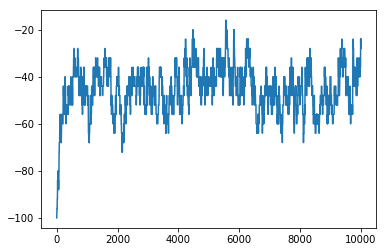

In [26]:
# 
# set simulation parameters
#
N = 100
J = 1.0 # Arbitrary units (kb=1.0)
B = 0.0
T = 2.0 # Temperature will be given in units of kb/J
n_steps = 10000
#
# perform the simulation
#
s = initial('down',N)
energies,magnetizations,microstates = montecarlo(s,J,B,T,N,n_steps)
#
# plot results
#
plt.plot(energies)
plt.show()

The following block plots the energy together with the magnetization per spin and the spin configuration (yellow/purple for up/down spins) as a function to MC step. 

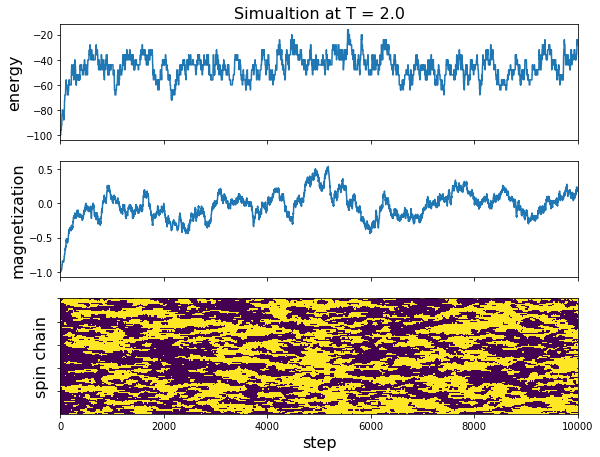

In [28]:
fig,ax = plt.subplots(3,sharex=True,figsize=(8,6))
fig.tight_layout()
ax[0].set_title('Simualtion at T = %2.1f'%T,fontsize=16)
ax[0].set_ylabel('energy',fontsize=16)
ax[0].set_xmargin(0)
ax[0].plot(energies)
ax[1].set_ylabel('magnetization',fontsize=16)
ax[1].set_xmargin(0)
ax[1].plot(magnetizations)
ax[2].set_ylabel('spin chain',fontsize=16)
ax[2].yaxis.set_ticklabels([])
ax[2].imshow(microstates.T,aspect='auto')
ax[2].set_xlabel('step',fontsize=16)
plt.show()

Once you know the number of equilibration steps that you need to skip in computing the averages, you can compute the average energy as a function of temperature. The following block performs the same commands as before, but for a range of temperatures, going from high temperatures towards 0. 

In [37]:
# global simulation setup
#
N = 100
J = 1.0 # Arbitrary units (kb=1.0)
B = 0.0
n_steps=10000 # NOTE: this number can be increased to improve the accuracy of the calculations
n_equilibration=10 # NOTE: this number needs to be changes, use the number that you estimated above
#
# setting up the range of temperatures
#
n_temperatures=10
T_max = 1.
T_min = 0.
#
# initializing the arrays that will hold the results
#
temperatures=np.zeros(n_temperatures)
mean_energies=np.zeros(n_temperatures)
mean_magnetizations=np.zeros(n_temperatures)
#
s = initial('random',N)
for i,T in enumerate(np.linspace(T_max,T_min,n_temperatures,False)):
    energies,magnetizations,microstates = montecarlo(s,J,B,T,N,n_steps)
    temperatures[i]=T
    mean_energies[i]=np.average(energies[n_equilibration:])
    s=microstates[-1,:].copy()

Compare the computed results with the analytic expression

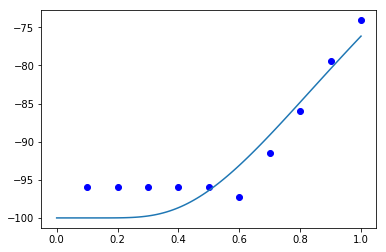

In [36]:
plt.plot(temperatures,mean_energies,'bo')
plt.plot(analytic_energy(N,J,T_max,100)[0],analytic_energy(N,J,T_max,100)[1])
plt.show()